# MA - INF 2201 - Computer Vision WS 22/23

### Exercise Sheet 06



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv

## **2.** Kalman Filtering

You need to implement the basic Kalman Filtering algorithm. You observe a set of 2D noisy observations (xi,yi) which are the coordinates of the 2D space as shown in Figure 1.

**State**: The state of the object should be the 4D vector (x,y,vx,vy) which denote
the location and the velocity in each axis.

**Initial State**: You should consider the initial state of (−10,−150,1,−2).

**Time Evolution Equation**: What should be the time evolution equation?
**Measurement Equation**: What should be the measurement equation?

Code for reading observations is provided. You should write code for performing the
kalman filtering. You may use numpy for matrix operations. At the end visualize
the filtered output. Use the template task02.py.

(5 points)

In [1]:
def get_data_at_iteration(n, datalist):
    x_1 = [x[0] for x in datalist[:n+1]]
    y_1 = [x[1] for x in datalist[:n+1]]

    return x_1, y_1 


class KalmanFilter(object):
    def __init__(self, psi, sigma_p, phi, sigma_m):
        self.psi = psi
        self.sigma_p = sigma_p
        self.phi = phi
        self.sigma_m = sigma_m
        # self.state = mu_t
        self.state = None
        # self.cov = sigma_t
        self.convariance = None
        self.tau = tau

        # state list for previous states
        self.states = []

    def init(self, init_state):
        self.state = init_state
        self.variance = self.sigma_p

    def track(self, xt):
        
        # State prediction:
        mu_plus = self.psi @ self.state

        # variance prediction
        sigma_plus = self.sigma_p + self.psi @ self.variance @ self.psi.T

        # kalman gain
        kalman_1 = self.sigma_m + self.phi @ sigma_plus @ self.phi.T
        kalman_inv = np.linalg.inv(kalman_1)
        kalman_gain = sigma_plus @ self.phi.T @ kalman_inv

        # state update mu_m is set difference between next state and first state
        pred = (xt -  self.phi @ mu_plus)
        new_state = mu_plus + kalman_gain @ pred

        # variance update
        new_convariance = (np.identity(self.psi.shape[1]) - kalman_gain @ self.phi) @ sigma_plus

       
        self.state = new_state
        self.convariance = new_convariance

                
    def get_current_location(self):
        # multiply with phi to only get location
        return self.state

def perform_tracking(tracker, observations):
    track = []
    for t in range(len(observations)):
        tracker.track(observations[t])
        track.append(tracker.get_current_location())
    return track

def get_world_model():
    psi = np.array([[1, 0, 1.5, 0],
                    [0, 1, 0, 0.5],
                    [0, 0, -1, 0],
                    [0, 0, 0, -2]])
    sp = 0.001
    sigma_p = np.array([[sp, 0, 0, 0],
                        [0, sp, 0, 0],
                        [0, 0, sp, 0],
                        [0, 0, 0, sp]])

    phi = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]])
    sm = 0.05
    sigma_m = np.array([[sm, 0],
                        [0, sm]])

    init_state = np.array([-10, -150, 1, -2])

    return psi, sigma_p, phi, sigma_m, init_state

(820, 2)


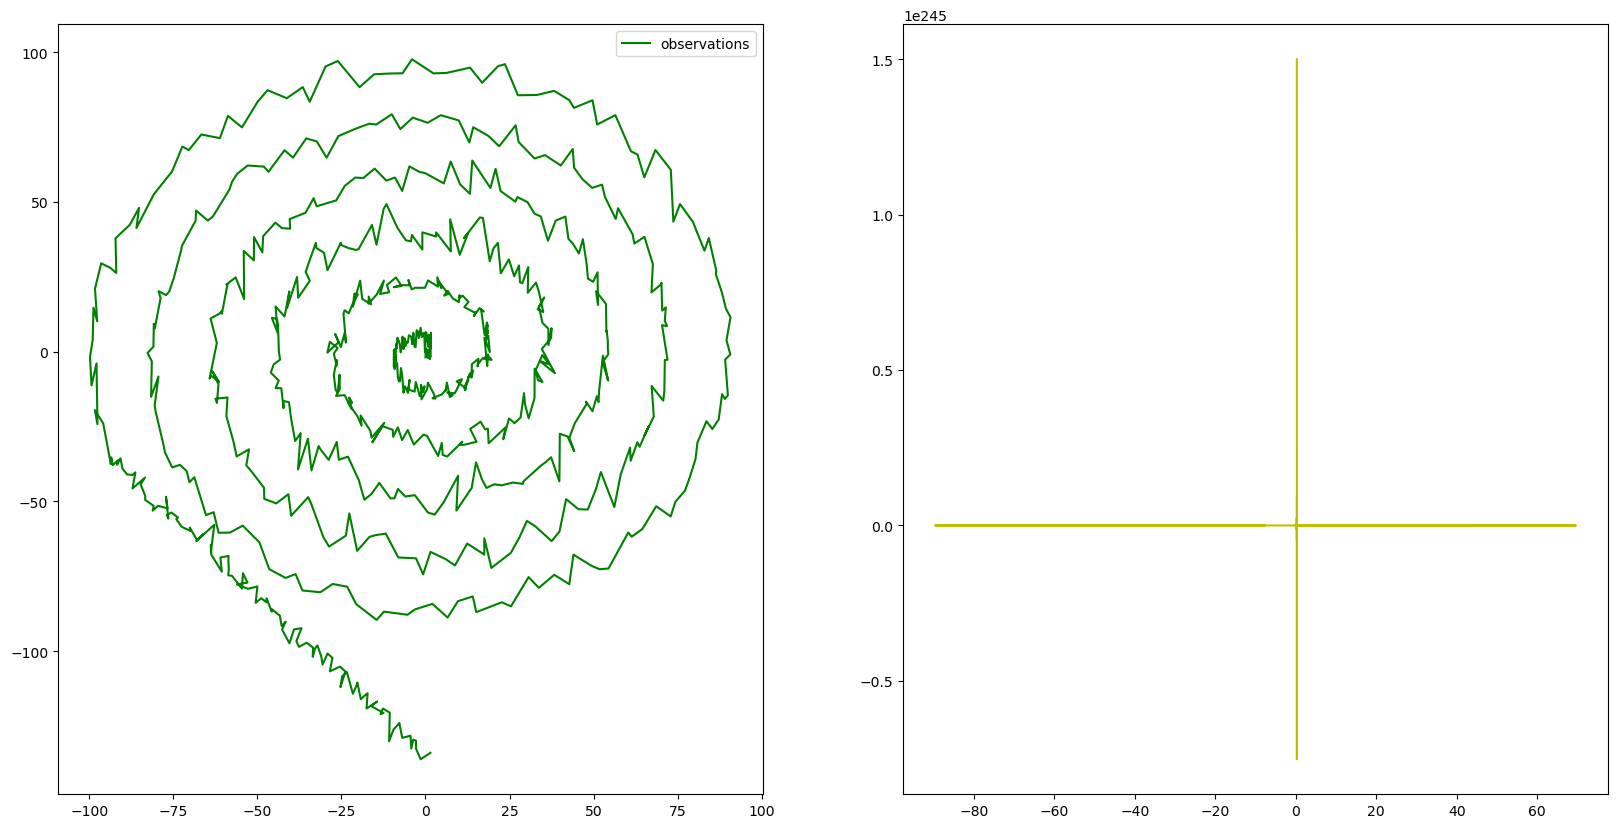

In [18]:
psi, sigma_p, phi, sigma_m, init_state = get_world_model()

observations = np.load('data/observations.npy')

print(observations.shape)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

kalman_filter = KalmanFilter(psi, sigma_p, phi, sigma_m, tau=3)
kalman_filter.init(init_state)
track = perform_tracking(kalman_filter, observations)

num_steps = len(observations) 
for n in range(num_steps):
    ax1.clear()
    ax2.clear()
    o_x, o_y = get_data_at_iteration(n, observations) 
    t_x, t_y = get_data_at_iteration(n, track) 
        
    ax1.plot(o_x, o_y, 'g', label='observations')
    ax2.plot(t_x, t_y, 'y', label='Kalman')
    ax1.legend()
    #plt.pause(0.01)
#plt.pause(3)

In [19]:
print(t_x[len(t_x)-1], t_y[len(t_y)-1])
print(kalman_filter.get_current_location())

0.28087707139016554 1.4995029036799064e+245
[ 2.80877071e-001  1.49950290e+245  2.93390042e-003 -9.24666468e+245]


We can see that the Y velocity is exploding. I see no error with the equation so I don't know the reason but the given psi for the velocity being to high.

## **3.** Background Subtraction using Gaussian Mixture Models

In this exercise we want to perform background subtraction for the provided image.
The image comes with a rectangular bounding box that contains some skin color
pixels (foreground). For this task you are required to implement a Gaussian Mixture
Model and the EM algorithm for training. Assume that all variance matrices are
diagonal.

**(a)** Implement the function fit single gaussian which fits a single Gaussian to provided data.
(1 point)

**(b)** GMMs rely on a good initialization. One strategy is to start with a single
Gaussian model, split it into two distributions (GMM with two mixtures) and
train it using the EM algorithm. For a GMM with four mixtures, both of the
previous distributions can be splitted again. Implement the split function that
doubles the number of components in the current Gaussian mixture model. In
particular, generate 2K components out of K components as follows:

- Duplicate the weights $\sigma$k so you have 2K weights. Divide by two to ensure $\sum_k \sigma_k = 1$.
- For each mean $\mu_k$, generate two new means $\mu_{k1} = \mu_{k} +  \cdot \epsilon_k$ and $\mu_{k2} = \mu_{k} -  \cdot \epsilon_k$.
- Duplicate the K diagonal variance matrices so you have 2K diagonal
variance matrices.
(2 points)

**(c)** Implement the EM algorithm to train the GMM.
(5 points)

**(d)** Background Subtraction Train a GMM with 4 components (start with a
single Gaussian and do 2 component splits) for the background pixels. Using
the thresholding approach from the lecture, set every pixel in the image to zero
which is above a threshold τ. Display the resulting image.
(2 points)

In [4]:
def read_image(filename):
    '''
    load the image and foreground/background parts
    image: the original image
    background/foreground: numpy array of size (n_pixels, 3) (3 for RGB values), i.e. the data you need to train the GMM
    '''
    image = cv.imread(filename) / 255
    height, width = image.shape[:2]
    bounding_box = np.zeros(image.shape)
    bounding_box[75:490, 130:250, :] = 1
    foreground = image[bounding_box == 1].reshape((-1, 3))
    background = image[bounding_box == 0].reshape((-1, 3))
    return image, foreground, background

'\nTODO: compute p(x|w=background) for each image pixel and manipulate the image such that \neverything below the threshold is black, display the resulting image\nHint: Slide 64\n'

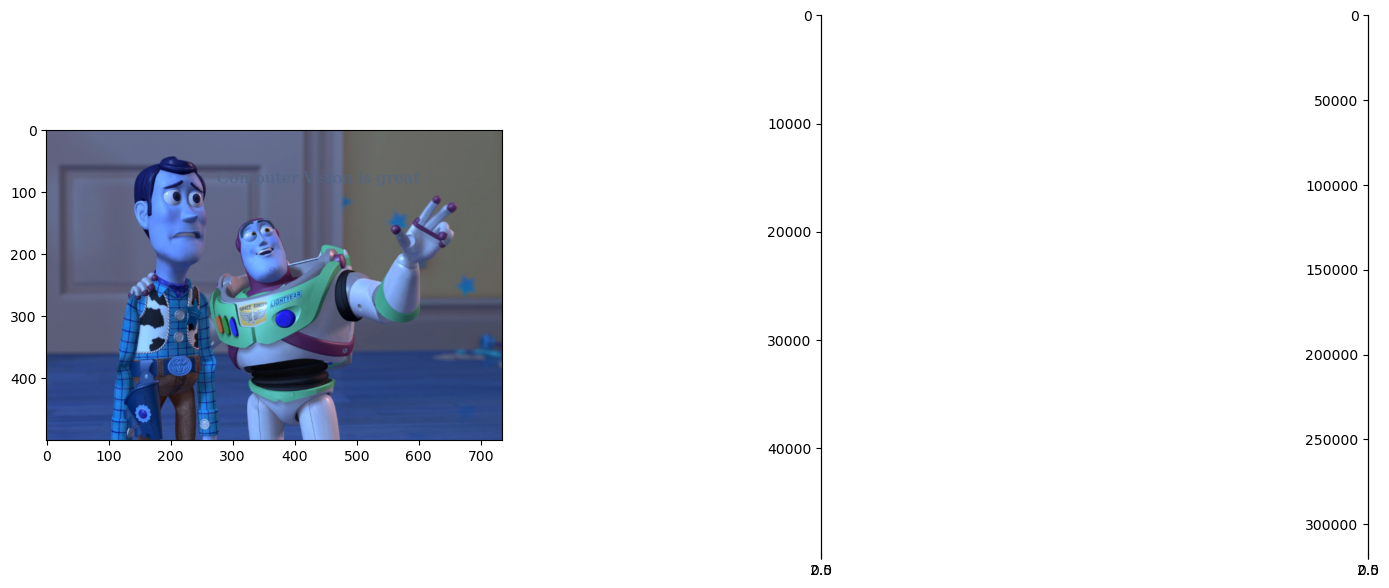

In [5]:
image, foreground, background = read_image('data/cv_is_great.png')

_, ax = plt.subplots(1, 3, figsize=(20,7))
ax[0].imshow(image)
ax[1].imshow(foreground)
ax[2].imshow(background)

'''
TODO: compute p(x|w=background) for each image pixel and manipulate the image such that 
everything below the threshold is black, display the resulting image
Hint: Slide 64
'''


In [29]:
class Gaussian_Mixture_Model():

    def fit_single_gaussian(self, data):
        # to create a gaussian we need mean and variance
        self.weights = np.array([[1]])
        self.mean = np.mean(data, axis=0, keepdims=True)[:, None, :]
        # save diagonal variance values in an array
        self.var = np.var(data, axis=0, keepdims=True)[:, None, :]

    def split_gaussian(self, epsilon):
        # duplicate weights and divide by 2
        self.weights = np.vstack((self.weights/2, self.weights/2))
        # new mean according to subtask b.
        new_mean1 = self.mean + epsilon * self.var
        new_mean2 = self.mean - epsilon * self.var 
        self.mean = np.vstack((new_mean1, new_mean2))
        # duplicate variance matrix
        self.var = np.vstack(((self.var, self.var)))

    def gaussian(self, size):
        # set amount of gaussian models and channels
        x = np.linspace(0, size, size, endpoint=True)
        gaussian = (np.exp(
                -np.power(x[None, :, None] - self.mean, 2) / (2 * np.power(self.var, 2))
            ))
        return gaussian

    # EM Algorithm:
    def e_step(self, data):
        # calculate r score, rik is kth responsibility from gaussian for the ith data point
        self.gaussians = self.gaussian(size=data.shape[0])
        
        r_numerator = self.gaussians * self.weights[:, None, :]
        # take sum of all ith data point (pixel), add constant for numerical stability
        r_denominator = np.sum(r_numerator, axis = 1, keepdims=True)
        # subtract with log for numerical stability (both are log already)
        print(r_numerator, r_denominator)
        r = r_numerator / r_denominator
        print(np.exp(r_denominator))
        return r 

    def m_step(self, data, r):
        self.weights = np.exp(np.log(np.sum(r, axis=1)) - np.log((np.sum(r))))
        
        # gaussian and add constant to dodge division by 0
        self.mean = np.sum((r * data), axis=1, keepdims=True) / (np.sum(r, axis=1, keepdims=True))
        # compute var with new means, add constant to division
        self.var = np.sum(
            (r * (data[None, :, :] - self.mean) * (data[None, :, :] - self.mean)
            ), axis=1, keepdims=True) / (np.sum(r, axis=1, keepdims=True) )

    def expectation_max(self, data, iterations):
        # do the e-step then the m-step
        for _ in range(iterations):
            r = self.e_step(data)
            self.m_step(data, r)
            
    def train_loop(self, data, splits, iterations, epsilon=0.01):
        self.fit_single_gaussian(data)
        # split depending on how many splits are given
        for i in range(splits):
            self.split_gaussian(epsilon)
        self.expectation_max(data, iterations)

    def get_probabilities(self, data):
        self.gaussians = self.gaussian(size=data.shape[0])
        return self.gaussians
        


In [31]:
'''
TODO: compute p(x|w=background) for each image pixel and manipulate the image such that everything below the threshold is black, display the resulting image
Hint: Slide 64
'''
image, foreground, background = read_image('data/cv_is_great.png')
gmm = Gaussian_Mixture_Model()
gmm.train_loop(background, 1, 2)

[[[8.79893257e-124 1.34576412e-124 1.96081326e-102]
  [0.00000000e+000 0.00000000e+000 9.34059679e-097]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]
  ...
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]]

 [[1.41533807e-123 2.16812320e-124 3.02031266e-102]
  [0.00000000e+000 0.00000000e+000 6.13643074e-097]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]
  ...
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]
  [0.00000000e+000 0.00000000e+000 0.00000000e+000]]] [[[8.79893257e-124 1.34576412e-124 9.34061640e-097]]

 [[1.41533807e-123 2.16812320e-124 6.13646094e-097]]]
[[[1. 1. 1.]]

 [[1. 1. 1.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]] [[[0. 0. 0.]]

 [[0. 0. 0.]]]
[[[1. 1. 1.]]

 [[1.

/tmp/ipykernel_1040/4183151396.py:24: RuntimeWarning: divide by zero encountered in divide
  -np.power(x[None, :, None] - self.mean, 2) / (2 * np.power(self.var, 2))
/tmp/ipykernel_1040/4183151396.py:38: RuntimeWarning: invalid value encountered in divide
  r = r_numerator / r_denominator


## !!Problems with Numerical Stability and low numbers!!

(500, 735, 3)
2.5171232810269974e-97
0.0
[[4.46437412e-123 6.83333203e-124 9.73497792e-102]
 [0.00000000e+000 0.00000000e+000 5.03424656e-097]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000]]


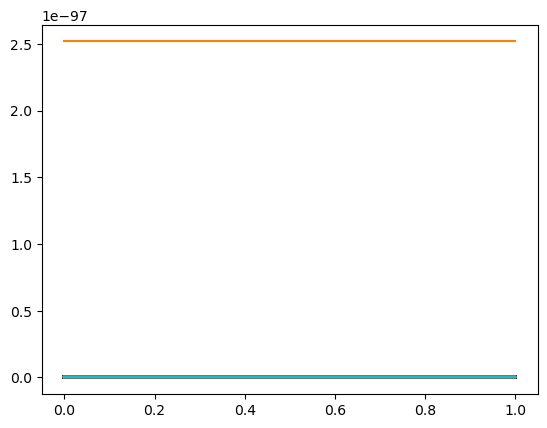

In [20]:
_, ax = plt.subplots(1,1)
print(image.shape)
gmm_gaussians = gmm.get_probabilities(image)
ax.plot(gmm_gaussians[:,:,2])
print(np.max(gmm_gaussians))
print(np.min(gmm_gaussians))
print(np.sum(gmm_gaussians, axis=0))
threshold = 0.15
gmm_gaussians[gmm_gaussians > threshold]
print(gmm)
